In [54]:
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd
import pandas_datareader as web
from datetime import datetime
from datetime import timedelta  
import numpy as np
import pyfolio as pf
import seaborn as sn
from tqdm import tqdm

# Key points:
Momentum strategy:

1)Select the (n) stocks with best peformace during the last (k) months and hold them for the next (q) months

2)Adjust the position acording to the portifolio volatility

3)Create a Long-Short portifolio following with the strategy defined in 1)

In [55]:
def ret_date(price,tickers,datei,datef,a=False):
    tickersaux=tickers[tickers!=''].dropna(axis=1).values[0]
    tickers=[x for x in tickersaux+' Equity']
    #print (tickers)
    price=price[tickers]
    ret=price.pct_change()
    ret=ret.loc[datei:datef]
    ret=(ret+1).cumprod()
    lastdate=ret.iloc[:,-1].index[-1]
    ret = ret.sort_values(by=lastdate,axis=1, ascending=a)    
    return ret

def portifolio_rebalance(port_w,date):
    port_w.loc[date]=1/len(port_w.columns)
    return port_w

In [56]:
tickers = pd.read_csv('SMLL_Stocks.csv',
                               parse_dates = ['Date'],
                               index_col = 'Date').drop('DateString', axis = 1).fillna('')

close_smll = pd.read_csv('SMLL_Prices.csv', parse_dates = ['Date'], index_col = 'Date')


In [57]:
ret_smll=close_smll.pct_change()
top=10 #Number of stocks selected
dt=364 # Holding period
window=dt #Look back return period
di=datetime(2009,1,1)
df=datetime(2020,1,1)
t=di+timedelta(days=dt)
ti=[]
tf=[]
holding=[]
col=[f'Asset{i}' for i in range(top)]
portifolio=pd.DataFrame(index=ret_smll.index,columns=col)
ret=pd.DataFrame(index=ret_smll.index,columns=col)
d1,d2=t-timedelta(days=window),t

#Choosing the best performer from previous period
while (t<df):
    ti.append(d1)
    tf.append(d2)
    momentum_stocks=ret_date(close_smll,tickers.loc[d1:d2][-1:],d1,d2).columns[:top]
    holding.append(momentum_stocks)
    t=t+timedelta(days=dt)
    d1,d2=t-timedelta(days=window),t
    for i in range (top):
        portifolio[f'Asset{i}'].loc[d1:d2]=momentum_stocks[i]
        ret[f'Asset{i}'].loc[d1:d2]=ret_smll[momentum_stocks[i]].loc[d1:d2]

portifolio=portifolio.dropna()
ret=ret.dropna()

In [58]:
# Calculating portifolio return
weight_portifolio=pd.DataFrame(index=ret.index,columns=col)
weight_portifolio=portifolio_rebalance(weight_portifolio,weight_portifolio.index[0])
ret_portifolio=pd.DataFrame(index=ret.index)
ret_portifolio['Portifolio']=0
for i in tqdm(range(1,len(ret_portifolio)),position=0, leave=True):
    ret_portifolio['Portifolio'].iloc[i-1]=(weight_portifolio.iloc[i-1]*ret.iloc[i-1]).sum(axis=0)
    weight_portifolio.iloc[i]=(weight_portifolio.iloc[i-1])*(1+ret.iloc[i-1])/(1+ret_portifolio['Portifolio'].iloc[i-1])
    if ((i%(dt))==0):
        weight_portifolio=portifolio_rebalance(weight_portifolio,weight_portifolio.index[i])

#ret_portifolio

100%|██████████| 2626/2626 [00:14<00:00, 185.29it/s]


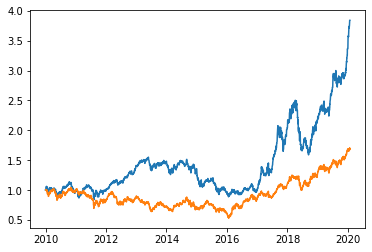

In [59]:
r=((ret_portifolio['Portifolio'])+1).cumprod()
ibov = (web.get_data_yahoo(['^BVSP'], start = r.index[0], end = r.index[-1])['Adj Close'].pct_change()[1:]+1).cumprod()
fig,aux=plt.subplots()
aux.plot(r)
aux.plot(ibov)
plt.show()

Start date,2010-01-01
End date,2020-01-24
Total months,125
,Backtest
Annual return,13.8%
Cumulative returns,284.1%
Annual volatility,20.3%
Sharpe ratio,0.74
Calmar ratio,0.32
Stability,0.53
Max drawdown,-42.7%


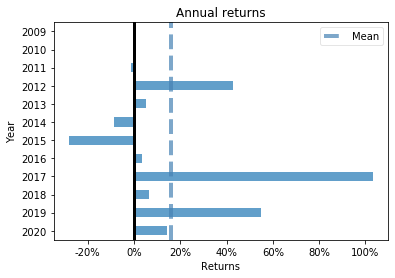

In [100]:
pf.show_perf_stats(r.pct_change().dropna())
pf.plot_annual_returns(r.pct_change())


# Assets turn over

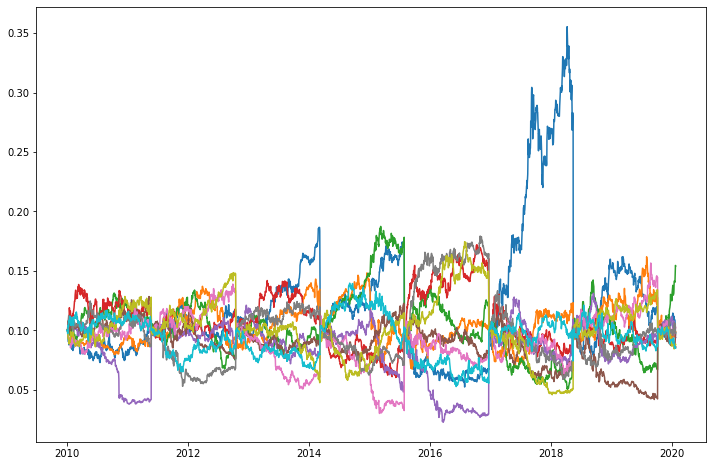

In [61]:
fig,aux=plt.subplots(figsize=(12,8))
aux.plot(weight_portifolio)
plt.show()

# Volatility adjust allocation

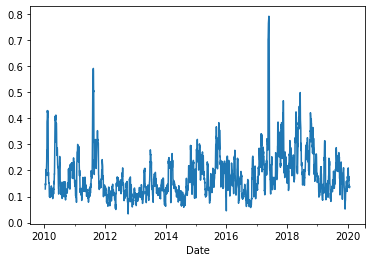

In [62]:
win=10
vol=r.pct_change().rolling(win).std().dropna()*np.sqrt(252)
vol.plot()
plt.show()

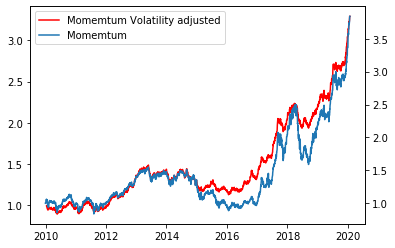

In [63]:
tgt=0.1
w=tgt/vol
rvol=((r.pct_change())*w+1).cumprod()
fig,ax=plt.subplots()
l1=ax.plot(rvol,'r',label='Momemtum Volatility adjusted')
ax=ax.twinx()
l2=ax.plot(r,label='Momemtum')

lns = l1+l2
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, loc=0)
plt.show()

Start date,2010-01-15
End date,2020-01-24
Total months,124
,Backtest
Annual return,12.2%
Cumulative returns,231.3%
Annual volatility,10.3%
Sharpe ratio,1.17
Calmar ratio,0.51
Stability,0.80
Max drawdown,-24.1%


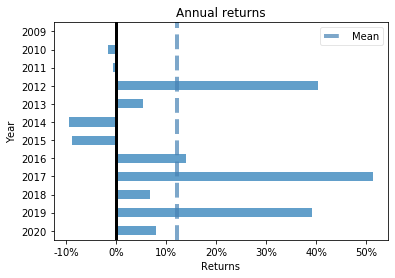

In [99]:
pf.show_perf_stats(rvol.pct_change().dropna())
pf.plot_annual_returns(rvol.pct_change())


# Worst Peformers portifolio

In [65]:
#top=10 #Number of stocks selected
#dt=364 # Holding period
#window=dt #Look back return period
#di=datetime(2009,1,1)
#df=datetime(2020,1,1)

t=di+timedelta(days=dt)
ti=[]
tf=[]
holding_s=[]
col=[f'Asset{i}' for i in range(top)]
portifolio_s=pd.DataFrame(index=ret_smll.index,columns=col)
ret_s=pd.DataFrame(index=ret_smll.index,columns=col)
d1,d2=t-timedelta(days=window),t

#Choosing the stocks with worst performance from the last period
while (t<df):
    ti.append(d1)
    tf.append(d2)
    momentum_stocks_s=ret_date(close_smll,tickers.loc[d1:d2][-1:],d1,d2,a=True).columns[:top]
    holding_s.append(momentum_stocks_s)
    t=t+timedelta(days=dt)
    d1,d2=t-timedelta(days=window),t
    for i in range (top):
        portifolio_s[f'Asset{i}'].loc[d1:d2]=momentum_stocks_s[i]
        ret_s[f'Asset{i}'].loc[d1:d2]=ret_smll[momentum_stocks_s[i]].loc[d1:d2]

portifolio_s=portifolio_s.dropna()
ret_s=ret_s.dropna()

In [67]:
# Calculating portifolio return
weight_portifolio_s=pd.DataFrame(index=ret_s.index,columns=col)
weight_portifolio_s=portifolio_rebalance(weight_portifolio_s,weight_portifolio_s.index[0])
ret_portifolio_s=pd.DataFrame(index=ret_s.index)
ret_portifolio_s['Portifolio']=0
for i in tqdm(range(1,len(ret_portifolio_s)),position=0, leave=True):
    ret_portifolio_s['Portifolio'].iloc[i-1]=(weight_portifolio_s.iloc[i-1]*ret_s.iloc[i-1]).sum(axis=0)
    weight_portifolio_s.iloc[i]=(weight_portifolio_s.iloc[i-1])*(1+ret_s.iloc[i-1])\
    /(1+ret_portifolio_s['Portifolio'].iloc[i-1])
    
    if ((i%(dt))==0):
        weight_portifolio_s=portifolio_rebalance(weight_portifolio_s,weight_portifolio_s.index[i])

#ret_portifolio

100%|██████████| 2626/2626 [00:17<00:00, 152.66it/s]


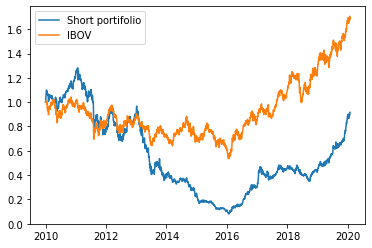

In [69]:
r_s=((ret_portifolio_s['Portifolio'])+1).cumprod()
ibov = (web.get_data_yahoo(['^BVSP'], start = r_s.index[0], end = r_s.index[-1])['Adj Close'].pct_change()[1:]+1).cumprod()
fig,aux=plt.subplots()
aux.plot(r_s,label='Short portifolio')
aux.plot(ibov,label='IBOV')
plt.legend()
plt.show()

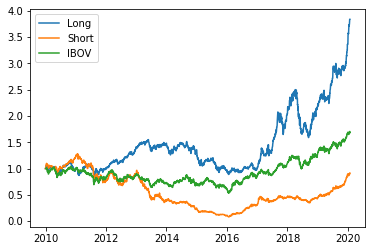

In [77]:
fig,aux=plt.subplots()
aux.plot(r,label='Long')
aux.plot(r_s,label='Short')
aux.plot(ibov,label='IBOV')
plt.legend()
plt.show()

# Long-short portifolio

In [83]:
col=['long','short']
weight_portifolio_ls=pd.DataFrame(index=ret.index,columns=col)
weight_portifolio_ls=portifolio_rebalance(weight_portifolio_ls,weight_portifolio_ls.index[0])
ret_ls=pd.DataFrame(index=ret.index,columns=col)
ret_ls['long']=ret_portifolio['Portifolio']
ret_ls['short']=-ret_portifolio_s['Portifolio']

ret_portifolio_ls=pd.DataFrame(index=ret.index,columns=['Portifolio'])

for i in tqdm(range(1,len(ret_portifolio_s)),position=0, leave=True):
    ret_portifolio_ls['Portifolio'].iloc[i-1]=(weight_portifolio_ls.iloc[i-1]*ret_ls.iloc[i-1]).sum(axis=0)
    weight_portifolio_ls.iloc[i]=(weight_portifolio_ls.iloc[i-1])*(1+ret_ls.iloc[i-1])\
    /(1+ret_portifolio_ls['Portifolio'].iloc[i-1])
    
    if ((i%(dt))==0):
        weight_portifolio_ls=portifolio_rebalance(weight_portifolio_ls,weight_portifolio_ls.index[i])

100%|██████████| 2626/2626 [00:17<00:00, 151.95it/s]


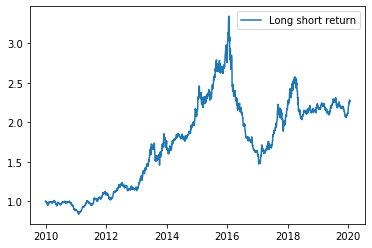

In [84]:
r_ls=(ret_portifolio_ls+1).cumprod()
fig,aux=plt.subplots()
aux.plot(r_ls,label='Long short return')
plt.legend()
plt.show()


Start date,2009-12-31
End date,2020-01-24
Total months,125
,Backtest
Annual return,8.2%
Cumulative returns,127.4%
Annual volatility,14.9%
Sharpe ratio,0.60
Calmar ratio,0.15
Stability,0.70
Max drawdown,-56.0%


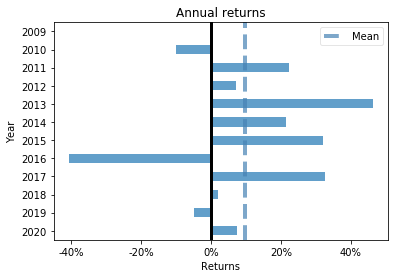

In [98]:
pf.show_perf_stats(r_ls['Portifolio'].pct_change())
pf.plot_annual_returns(r_ls['Portifolio'].pct_change())
